Using cpu device
Logging to ./ppo_bond_tensorboard/PPO_3


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 328  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 400         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014431642 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.625      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.104       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0194     |
|    value_loss           | 0.353       |
-----------------------------------------
----------------------------------

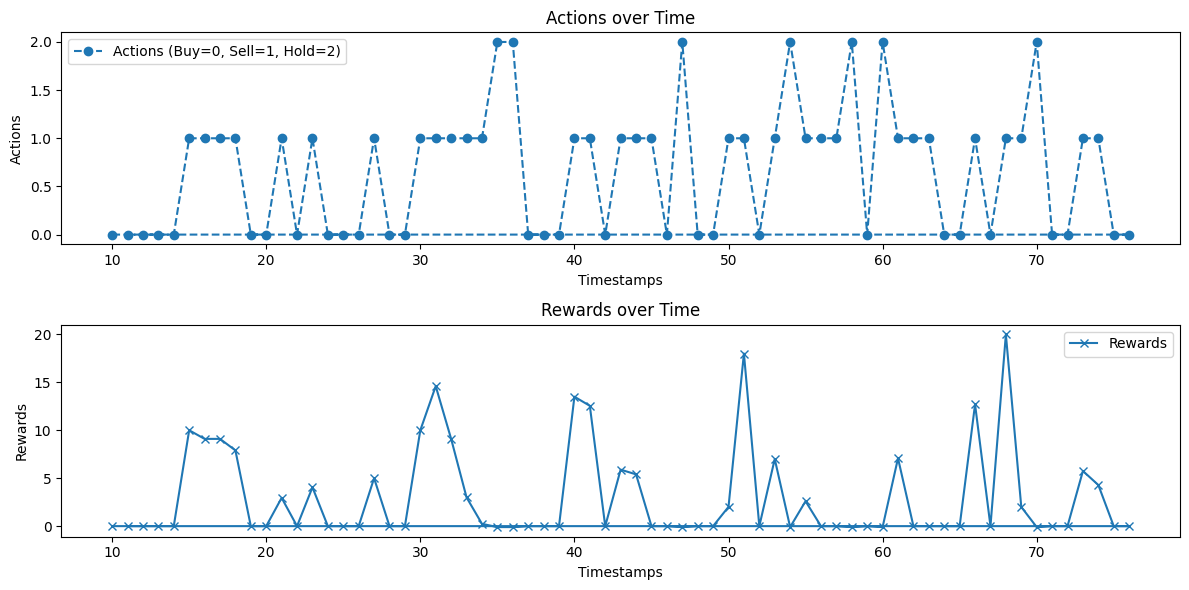

In [ ]:
!pip install shimmy stable-baselines3 transformers gymnasium torch matplotlib

import numpy as np
import pandas as pd
import gym
from gym import spaces
import torch
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecNormalize

# Load and clean the bond dataset
file_path = "/content/BOND DATA (2).csv"
data = pd.read_csv(file_path)
data.columns = data.columns.str.strip()

features = ['OPEN', 'HIGH', 'LOW', 'PREV. CLOSE', 'ltp', 'close', 'vwap', '52W H', '52W L', 'VOLUME', 'VALUE', 'No of trades']
for col in features:
    data[col] = data[col].replace({',': ''}, regex=True).astype(float)

bond_data = data[features].values

# Define the bond market environment
class BondMarketEnv(gym.Env):
    def __init__(self, bond_data, initial_cash=10000, seq_length=10):
        super(BondMarketEnv, self).__init__()
        self.bond_data = bond_data
        self.initial_cash = initial_cash
        self.seq_length = seq_length
        self.reset()

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(
            low=0, high=np.inf, shape=(bond_data.shape[1] * seq_length + 1,), dtype=np.float32
        )

    def reset(self):
        self.current_step = self.seq_length
        self.cash = self.initial_cash
        self.portfolio = []
        return self._next_observation()

    def _next_observation(self):
        obs = self.bond_data[self.current_step - self.seq_length:self.current_step]
        obs = obs.flatten().astype(np.float32)
        obs = np.append(obs, self.cash)
        return obs

    def step(self, action):
        reward = 0
        done = False
        current_price = self.bond_data[self.current_step][4]  # ltp

        if action == 0 and self.cash >= current_price:  # Buy
            self.portfolio.append(current_price)
            self.cash -= current_price

        elif action == 1 and self.portfolio:  # Sell
            bought_price = self.portfolio.pop(0)
            reward = current_price - bought_price
            self.cash += current_price

        # Small holding reward/penalty
        elif action == 2:
            reward = -0.1

        self.current_step += 1
        if self.current_step >= len(self.bond_data) - 1:
            done = True

        return self._next_observation(), reward, done, {"portfolio_value": sum(self.portfolio) + self.cash}

# Create and wrap environment
env = DummyVecEnv([lambda: BondMarketEnv(bond_data)])
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

# Train PPO agent with tuned hyperparameters
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    gamma=0.95,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    clip_range=0.2,
    ent_coef=0.005,
    tensorboard_log="./ppo_bond_tensorboard/"
)

model.learn(total_timesteps=20000)  # Increase timesteps
model.save("bond_ppo_model")

# Evaluate and visualize
env.training = False
env.norm_reward = False
obs = env.reset()
done = False

rewards, actions, timestamps = [], [], []

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)
    rewards.append(reward[0])
    actions.append(action[0])
    timestamps.append(env.get_attr('current_step')[0])

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(timestamps, actions, marker='o', linestyle='--', label='Actions (Buy=0, Sell=1, Hold=2)')
plt.title("Actions over Time")
plt.xlabel("Timestamps")
plt.ylabel("Actions")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(timestamps, rewards, marker='x', label='Rewards')
plt.title("Rewards over Time")
plt.xlabel("Timestamps")
plt.ylabel("Rewards")
plt.legend()

plt.tight_layout()
plt.show()

